In [25]:
# given some description of the encoding rule, expand a logical circuit into an encoded circuit
# this entails interleaving the logical circuit with syndrome measurement and error correction
# each logical operator should be expanded into the encoded manifold as well
# NOTE: we could think about how to generalize this to codes, but for now its okay to keep specific to ours
from quantum_logical.qudit_op import QutritUnitary
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import random_clifford
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
import qutip as qt
from quantum_logical.basis import RepetitionEncoding
from quantum_logical.basis import QutritPhaseRepetitionCode
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.passmanager import PassManager
from qiskit.converters import circuit_to_dag
from quantum_logical.encoded_layout import EncodedLayout
from qiskit.quantum_info import Operator
import numpy as np
from itertools import product
from quantum_logical.encoded_layout import EncodedCircuitExpansionPass
from qiskit.transpiler.passmanager import PassManager

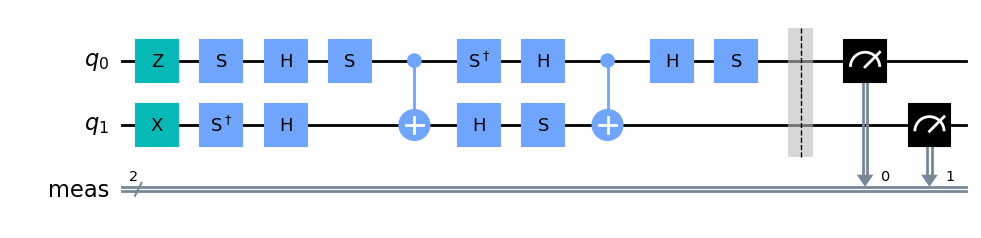

In [26]:
input_circuit = random_clifford(2, seed=1).to_circuit()
input_circuit = transpile(
    input_circuit,
    basis_gates=["sdg", "s", "h", "hdg", "x", "xdg", "z", "zdg", "cx", "id"],
    optimization_level=3,
)
input_circuit.measure_all()
input_circuit.draw(output="mpl")

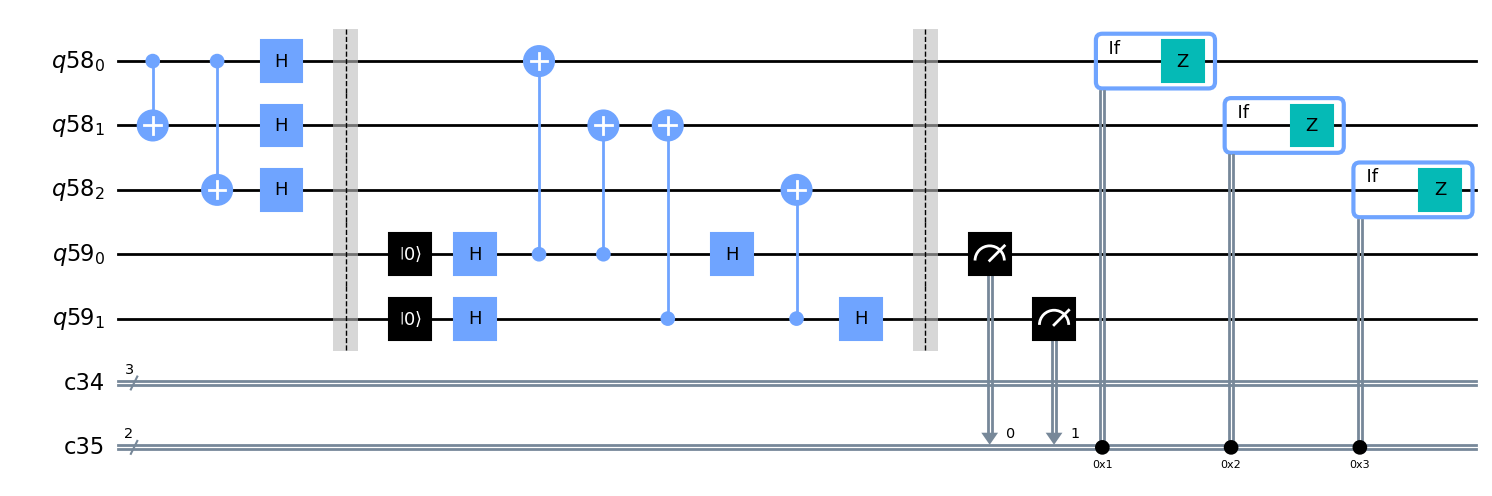

In [27]:
qr = QuantumRegister(3)
ar = QuantumRegister(2)
cqr = ClassicalRegister(3)
car = ClassicalRegister(2)
qc = QuantumCircuit(qr, ar, cqr, car)

encoding1 = RepetitionEncoding(phase_flip=True)
qc = encoding1.encoding_circuit(qc, qr)
qc.barrier()
qc = encoding1.stabilizer_subroutine(qc, qr, ar, car)
# encoding.decoding_circuit(qc, qr)
# qc.barrier()
qc.draw("mpl")

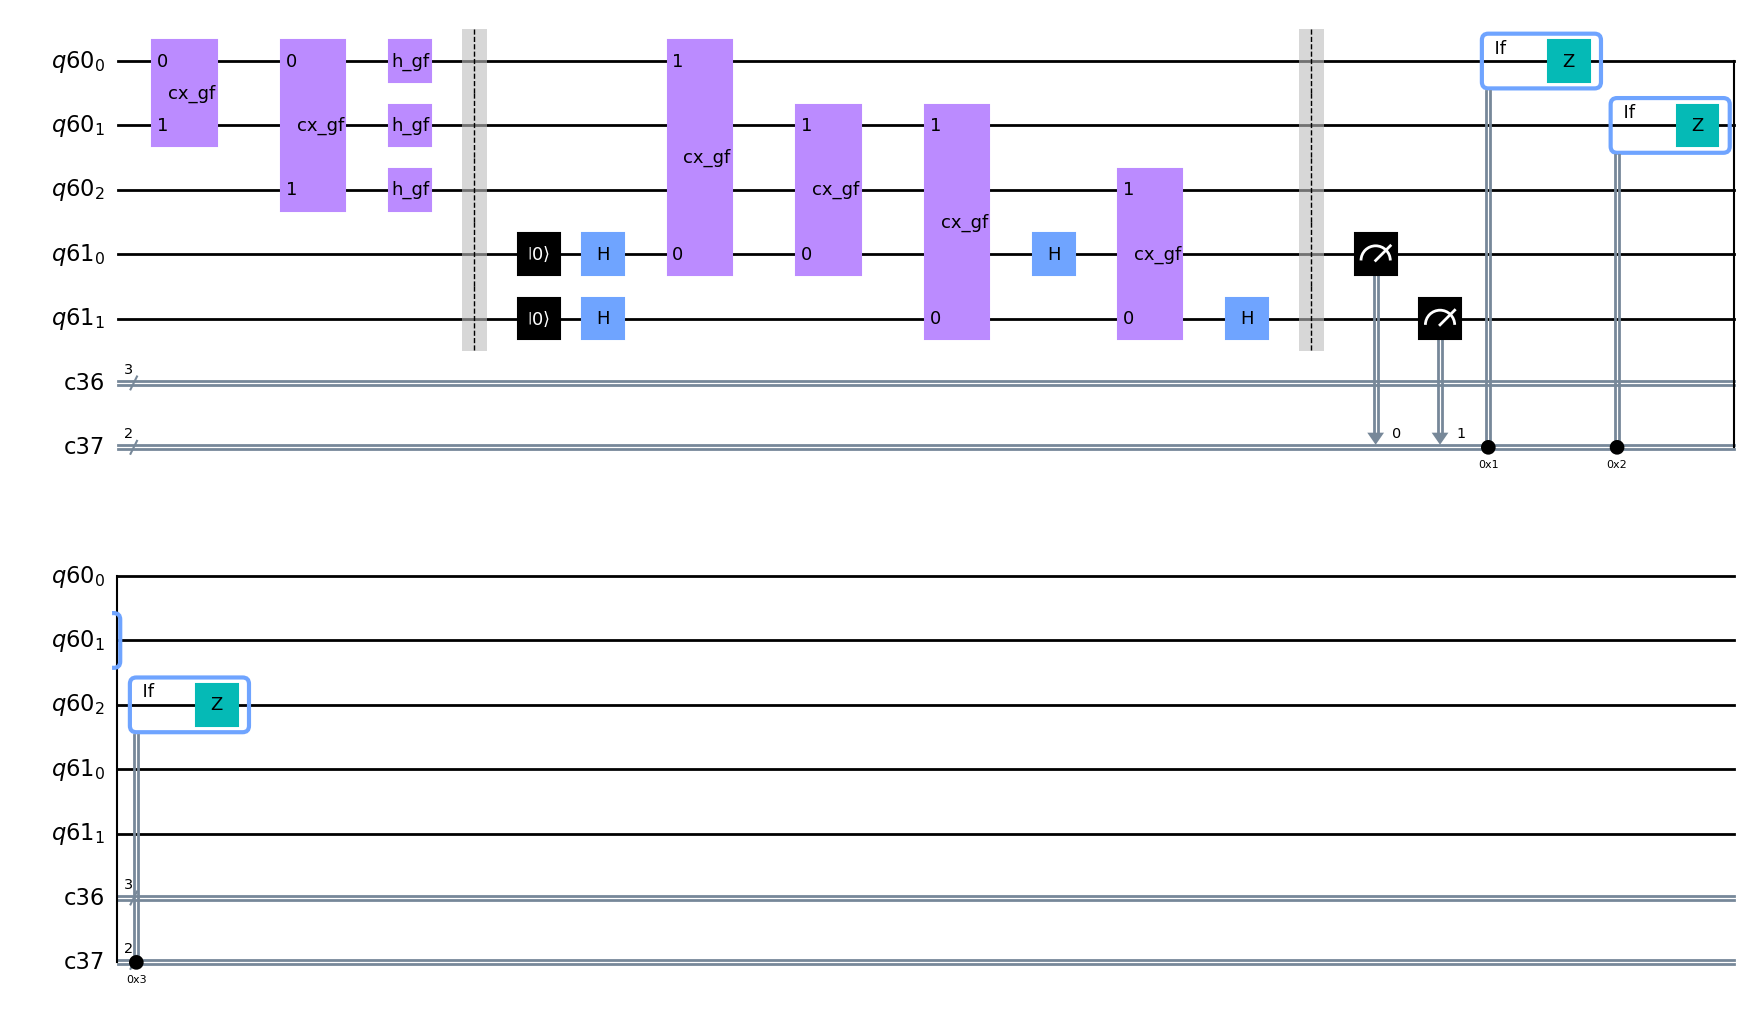

In [28]:
qr = QuantumRegister(3)
ar = QuantumRegister(2)
cqr = ClassicalRegister(3)
car = ClassicalRegister(2)
qc = QuantumCircuit(qr, ar, cqr, car)

encoding2 = QutritPhaseRepetitionCode()
qc = encoding2.encoding_circuit(qc, qr)
qc.barrier()
qc = encoding2.stabilizer_subroutine(qc, qr, ar, car)
# qc = encoding.decoding_circuit(qc, qr)
# qc.barrier()
qc.draw("mpl")

In [35]:
from quantum_logical.basis import cx_gf
from qutip import Qobj

Qobj(cx_gf.to_matrix())

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]

In [29]:
# TODO: references
# https://qiskit.org/documentation/stable/0.28/tutorials/noise/6_repetition_code.html
# https://github.com/qiskit-community/qiskit-qec/blob/main/src/qiskit_qec/circuits/repetition_code.py

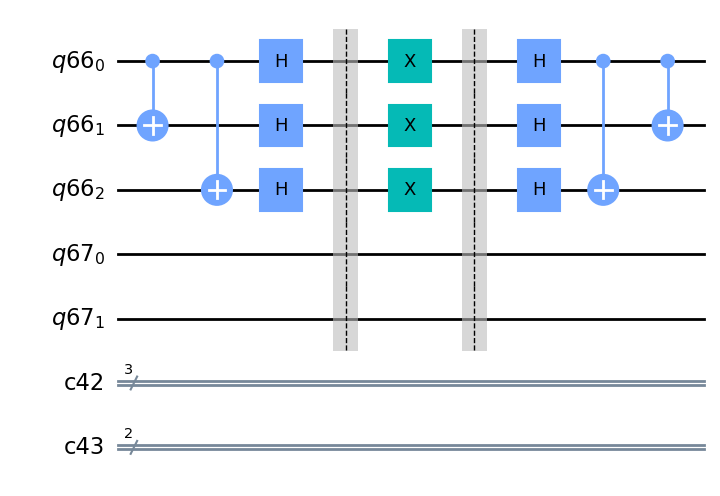

In [31]:
qr1 = QuantumRegister(3)
ar1 = QuantumRegister(2)
cqr1 = ClassicalRegister(3)
car1 = ClassicalRegister(2)
qr2 = QuantumRegister(3)
ar2 = QuantumRegister(2)
cqr2 = ClassicalRegister(3)
car2 = ClassicalRegister(2)
qc = QuantumCircuit(qr1, ar1, cqr1, car1)  # , qr2, ar2, cqr2, car2)

encoding = RepetitionEncoding(phase_flip=True)
qc = encoding.encoding_circuit(qc, qr1)
# qc = encoding.encoding_circuit(qc, qr2)
qc.barrier()

# searching for logical operator here
# qc.cx(qr1[0], qr2[0])
qc.x(qr1)
#

qc.barrier()
encoding.decoding_circuit(qc, qr1)
# encoding.decoding_circuit(qc, qr2)
display(qc.draw("mpl"))

# output what it did by considering the effective unitary between qr1[0] and qr2[0]
full_unitary = Operator(qc).data

In [ ]:
# FIXME doesn't work :)


def reduce_to_two_qubit_subspace(unitary, qubit_indices):
    """Reduces a multi-qubit unitary to a two-qubit unitary using isometric projection.

    Parameters:
        unitary (ndarray or Operator): A unitary operator in a multi-qubit Hilbert space.
        qubit_indices (list): List of two integer indices [index1, index2] specifying the two qubits to keep.

    Returns:
        ndarray: The unitary operator reduced to the two-qubit subspace.
    """
    if isinstance(unitary, Operator):
        unitary = unitary.data
    elif not isinstance(unitary, np.ndarray):
        raise ValueError("The unitary must be an ndarray or an Operator.")

    # Number of qubits in the original unitary
    num_qubits = int(np.log2(unitary.shape[0]))

    # if len(qubit_indices) != 2:
    #     raise ValueError("qubit_indices must be of length 2.")
    # if any(idx >= num_qubits for idx in qubit_indices):
    #     raise ValueError("Index out of range for the given number of qubits.")

    # Create the isometry
    isometry = np.zeros((4, 2**num_qubits))

    # Construct the isometry using tensor products of the basis states
    for i, (idx1, idx2) in enumerate(product(range(2), repeat=2)):
        # Build the basis state for the entire system with the specified qubits in state |idx1> and |idx2>
        basis_state = [0] * num_qubits
        basis_state[qubit_indices[0]] = idx1
        # basis_state[qubit_indices[1]] = idx2
        basis_state = int("".join(map(str, basis_state)), 2)

        # Set the corresponding row in the isometry matrix
        isometry[i, basis_state] = 1

    # Apply the isometric projection to the unitary
    reduced_unitary = isometry @ unitary @ isometry.T.conj()

    return reduced_unitary

In [ ]:
reduce_to_two_qubit_subspace(full_unitary, [0])

array([[1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 1.+0.j]])